# Modelling - Vanilla Algorithms Gridsearch MLR
Author: P.C.O. Maseland <br>
Date: 03 December 2021 <br>

In [19]:
# !!! RUN !!!
#Import packages/libraries
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#Linear Regression
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### Load Correct datafile

**prepared accelerometer, gyroscope and magnetometer csv**

In [2]:
# !!! RUN !!!
#local jupyter notebook path
path ="Totalset+slopes+mean+sd.csv"
df = pd.read_csv(path)

In [3]:
# !!! RUN !!!
#reorder such that labels are at the back
df = df[[c for c in df if c not in ['Subject ID','Activity']] 
       + ['Subject ID','Activity']]

**Activity coding**
- 'climbingdown' {0} 
- 'climbingup' {1} 
- 'jumping' {2} 
- 'lying' {3} 
- 'running' {4} 
- 'sitting' {5}
- 'standing' {6} 
- 'walking' {7}]

### Remove/Convert statistical NaN values
Since we calculated our rolled statistics over a nr of timesteps. The first nr of timesteps have a NaN, these are therefore useless. On the whole set we removed thereby 24336 rows, which is just a small fraction of 0.4% of the whole.

In [4]:
# !!! RUN !!!
df = df. dropna()

### Full set copy

In [5]:
# !!! RUN !!!
#create copy full set
fullset = df
print(fullset.shape)

#drop subject ID
fullset_without_subject = fullset.drop(columns=['Subject ID'])

#shuffle fullset
fullset_without_subject = fullset_without_subject.sample(frac=1)

(6059664, 86)


### Make new subset
With only time-base statistical values

In [7]:
# !!! RUN !!!
statistical_cols = [col for col in fullset_without_subject.columns if ('slope' in col 
                                                                      or 'mean' in col 
                                                                      or 'sd' in col
                                                                      or 'Activity' in col)]
statistical_cols

new_subset = fullset_without_subject[statistical_cols]
new_subset.shape

(6059664, 64)

### Multinomial Logistical Regression modelling

In [8]:
# !!! RUN !!!
def dataset_prep(dataset, filters):
    filterscolls = [col for col in dataset.columns if (filters in col or 'Activity' in col)]
    outputname = dataset[filterscolls]
    
    X = outputname.iloc[:,:-1]
    print(X.shape)

    y = outputname['Activity']
    print(y.shape)
    
    return outputname, X, y

#### Gridsearch multinomial logistic regression
using mean values of acc <br>

Solvers
For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
Only sag and saga work with scaled data, newton-cg takes lot oc computational time. So lbfgs is logical default option.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

##### Make sample dataset

In [12]:
acc_mean_subset, acc_meanX, acc_meany = dataset_prep(new_subset, 'acc_mean')
gyr_mean_subset, gyr_meanX, gyr_meany = dataset_prep(new_subset, 'gyr_mean')

(6059664, 7)
(6059664,)
(6059664, 7)
(6059664,)


##### Grid search param set up

In [20]:
penalty = ['l1','l2']
max_iter=[40, 80, 100] #add 140
C = np.linspace(0.1, 1.0, num=5)

#set params
param_grid = dict(max_iter=max_iter, C=C, penalty=penalty)

# Write your code below
acc_meanX.head()


,magnitude_chest_acc_mean,magnitude_forearm_acc_mean,magnitude_head_acc_mean,magnitude_shin_acc_mean,magnitude_thigh_acc_mean,magnitude_upperarm_acc_mean,magnitude_waist_acc_mean
5358686,7.353041,12.593770,7.916972,6.334679,12.384456,12.727567,13.770539
2944639,4.925388,6.818094,2.225232,18.314108,15.960121,14.145843,19.137262
5003424,8.457414,10.645859,9.058623,15.739791,8.905845,9.221570,7.758266
3500763,9.288422,10.357164,9.627246,10.174630,9.556443,10.437294,9.925295
3370883,9.475018,10.254427,9.623447,10.150041,9.761166,10.114934,9.794806


In [24]:
#model
model = LogisticRegression(multi_class='multinomial', 
                            solver='lbfgs', 
                            class_weight='balanced')

In [25]:
#set up gridsearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)

In [26]:
#run gridsearch
start_time = time.time()
grid_result = grid.fit(acc_meanX, acc_meany)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

C:\Users\31657\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\31657\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\31657\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\31657\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\31657\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Best: 0.497662 using {'C': 0.325, 'max_iter': 40, 'penalty': 'l2'}
Execution time: 27762.78554201126 ms


#### Use best model for testcases
Test on some subsets to see if results improved

#### best model

In [54]:
#best model
model = LogisticRegression(multi_class='multinomial', 
                            solver='lbfgs', 
                            penalty='l2', C=0.325, max_iter=70, 
                            class_weight='balanced')

In [59]:
def multivar_log_best(X, y):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)
    
    #model
    model = LogisticRegression(multi_class='multinomial', 
                            solver='lbfgs', 
                            penalty='l2', C=0.325, max_iter=140, 
                            class_weight='balanced')
    #fit model
    model.fit(X_train, y_train)
    #make prediction and evaluation
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return model, X_train
    

(6059664, 7)
(6059664,)
[[  5360   6404  17482  22624  26954   6473  13492  21727]
 [  6775  10872  18496  31789  16975  11921  20559  20459]
 [   524    160   4943   5688   5568    650   1569   1615]
 [    46    279    131 164965     35  17157   1368     80]
 [  2298   3513  13557   7048 118512   8659  29100  15119]
 [    44   1300    242   8658      7 111466  61872     73]
 [    33   1100    265   3780     38  28806 147779     69]
 [  8781  13707  21308  33552  42694  11240  14969  39204]]
              precision    recall  f1-score   support

           0       0.22      0.04      0.07    120516
           1       0.29      0.08      0.12    137846
           2       0.06      0.24      0.10     20717
           3       0.59      0.90      0.71    184061
           4       0.56      0.60      0.58    197806
           5       0.57      0.61      0.59    183662
           6       0.51      0.81      0.63    181870
           7       0.40      0.21      0.28    185455

    accuracy   

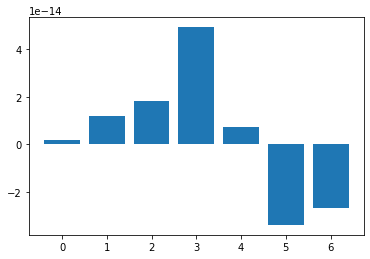

Index(['magnitude_chest_acc_mean', 'magnitude_forearm_acc_mean',
       'magnitude_head_acc_mean', 'magnitude_shin_acc_mean',
       'magnitude_thigh_acc_mean', 'magnitude_upperarm_acc_mean',
       'magnitude_waist_acc_mean'],
      dtype='object')


In [49]:
acc_mean_subset, acc_meanX, acc_meany = dataset_prep(new_subset, 'acc_mean')
mlog_acc_mean, acc_mean_train = multivar_log_best(acc_meanX, acc_meany)
multivar_log_importance(mlog_acc_mean, acc_mean_train)

(6059664, 7)
(6059664,)
[[ 33994  23743  20775    144   4915    101    490  36354]
 [ 15120  63218  21800     64   2252    144   4845  30403]
 [  2786   3902   8820      0   2495      4      8   2702]
 [    24    820    625 147135     56  32157   3138    106]
 [  5256   6076  14781   5557 144533   6682  12683   2238]
 [    63   1012    249  93484     16  50501  38205    132]
 [    90   2803    288  46012     13  50621  81442    601]
 [ 22609  43572   8251    148   3009    150    328 107388]]
              precision    recall  f1-score   support

           0       0.43      0.28      0.34    120516
           1       0.44      0.46      0.45    137846
           2       0.12      0.43      0.18     20717
           3       0.50      0.80      0.62    184061
           4       0.92      0.73      0.81    197806
           5       0.36      0.27      0.31    183662
           6       0.58      0.45      0.50    181870
           7       0.60      0.58      0.59    185455

    accuracy   

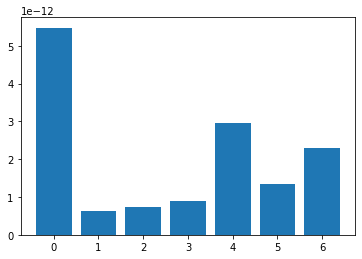

Index(['magnitude_chest_gyr_mean', 'magnitude_forearm_gyr_mean',
       'magnitude_head_gyr_mean', 'magnitude_shin_gyr_mean',
       'magnitude_thigh_gyr_mean', 'magnitude_upperarm_gyr_mean',
       'magnitude_waist_gyr_mean'],
      dtype='object')


In [63]:
gyr_mean_subset, gyr_meanX, gyr_meany = dataset_prep(new_subset, 'gyr_mean')
mlog_gyr_mean, gyr_mean_train = multivar_log_best(gyr_meanX, gyr_meany)
multivar_log_importance(mlog_gyr_mean, gyr_mean_train)

(6059664, 7)
(6059664,)
[[ 40672  24665  14274    163   7084    149    334  33175]
 [ 14968  80554   3197   1474    331   4902   3550  28870]
 [  3475    732  10805      0   4238      2      0   1465]
 [   206   1225    157 164979      8  13062   4319    105]
 [  5813   4146  37882   4035 120130   4041  18598   3161]
 [   172   1460     63  91077      8  71955  18807    120]
 [   226   4101     87  45344     11  51755  80140    206]
 [ 35313  58545   4446    144   2999    178    506  83324]]
              precision    recall  f1-score   support

           0       0.40      0.34      0.37    120516
           1       0.46      0.58      0.51    137846
           2       0.15      0.52      0.24     20717
           3       0.54      0.90      0.67    184061
           4       0.89      0.61      0.72    197806
           5       0.49      0.39      0.44    183662
           6       0.63      0.44      0.52    181870
           7       0.55      0.45      0.50    185455

    accuracy   

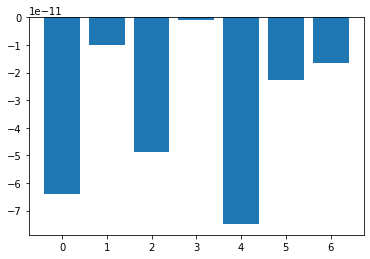

Index(['magnitude_chest_gyr_sd', 'magnitude_forearm_gyr_sd',
       'magnitude_head_gyr_sd', 'magnitude_shin_gyr_sd',
       'magnitude_thigh_gyr_sd', 'magnitude_upperarm_gyr_sd',
       'magnitude_waist_gyr_sd'],
      dtype='object')


In [51]:
gyr_sd_subset, gyr_sdX, gyr_sdy = dataset_prep(new_subset, 'gyr_sd')
mlog_gyr_sd, gyr_sd_train  = multivar_log_best(gyr_sdX, gyr_sdy)
multivar_log_importance(mlog_gyr_sd, gyr_sd_train)

(6059664, 7)
(6059664,)
[[ 44920  25625   9115     95  11738    139    392  28492]
 [ 20380  81243    489   2756    716   3739   2653  25870]
 [  2853    516   9153      0   7130      1      1   1063]
 [    98   1359      8 160258     13  12236  10035     54]
 [  9450   3299  69719   5370  84181   4977  18451   2359]
 [    38   1434      0  81522     22  72802  27833     11]
 [    36   2180      3  59409      3  48976  71247     16]
 [ 46714  70568   2302    150   5932    166    250  59373]]
              precision    recall  f1-score   support

           0       0.36      0.37      0.37    120516
           1       0.44      0.59      0.50    137846
           2       0.10      0.44      0.16     20717
           3       0.52      0.87      0.65    184061
           4       0.77      0.43      0.55    197806
           5       0.51      0.40      0.45    183662
           6       0.54      0.39      0.46    181870
           7       0.51      0.32      0.39    185455

    accuracy   

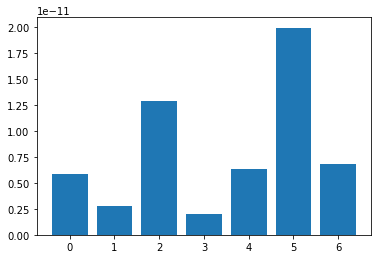

Index(['magnitude_chest_acc_sd', 'magnitude_forearm_acc_sd',
       'magnitude_head_acc_sd', 'magnitude_shin_acc_sd',
       'magnitude_thigh_acc_sd', 'magnitude_upperarm_acc_sd',
       'magnitude_waist_acc_sd'],
      dtype='object')


In [61]:
acc_sd_subset, acc_sdX, acc_sdy = dataset_prep(new_subset, 'acc_sd')
mlog_acc_sd, acc_sd_train  = multivar_log_best(acc_sdX, acc_sdy)
multivar_log_importance(mlog_acc_sd, acc_sd_train)

(6059664, 7)
(6059664,)
[[ 18533  20037  22407    163  12845    310   1608  44613]
 [ 14625  38551  28937   2648  10536   2537   5213  34799]
 [  2002   2428   7943     63   3357    148    669   4107]
 [   197    314    873 120309    485  48348  12644    891]
 [ 16560  22369  40265   8912  76836   9115  10316  13433]
 [   247    322   1444  83527    260  74214  21427   2221]
 [   322    748   2034  67125    183  59361  49711   2386]
 [ 17422  22728  22485    240   9466    260   2310 110544]]
              precision    recall  f1-score   support

           0       0.27      0.15      0.19    120516
           1       0.36      0.28      0.31    137846
           2       0.06      0.38      0.11     20717
           3       0.43      0.65      0.52    184061
           4       0.67      0.39      0.49    197806
           5       0.38      0.40      0.39    183662
           6       0.48      0.27      0.35    181870
           7       0.52      0.60      0.55    185455

    accuracy   

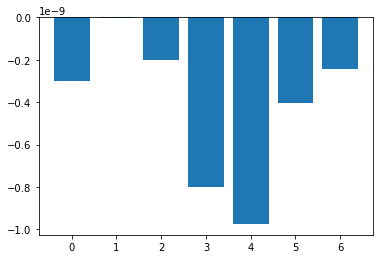

Index(['magnitude_chest_mag_sd', 'magnitude_forearm_mag_sd',
       'magnitude_head_mag_sd', 'magnitude_shin_mag_sd',
       'magnitude_thigh_mag_sd', 'magnitude_upperarm_mag_sd',
       'magnitude_waist_mag_sd'],
      dtype='object')


In [62]:
mag_sd_subset, mag_sdX, mag_sdy = dataset_prep(new_subset, 'mag_sd')
mlog_mag_sd, mag_sd_train  = multivar_log_best(mag_sdX, mag_sdy)
multivar_log_importance(mlog_mag_sd, mag_sd_train)